# 07 Raster2 Demo
## Reprojection, Clipping, Sampling, Zonal Stats
#### Featuring the best<sup>*</sup> raster of all: DEMs

UW Geospatial Data Analysis  
CEE498/CEWA599  
David Shean  

<sup>*</sup>An objective conclusion

## Objectives
* Demonstrate multiple approaches for "on-the-fly" raster data download
* Understand additional fundamental raster processing/analysis:
    * Reprojection
    * Clipping
    * Interpolation and sampling strategies
* Combine vector points and polygons with rasters for zonal statistics
* Understand processing strategies, derivative products, and common applications for a fundamental raster data product: DEMs
    * Slope and Aspect
    * Contour generation
    * Volume estimation (cut/fill analysis)

## What is a DEM?
DEM = Digital Elevation Model

A generic term for a 2D raster grid with values representing surface elevation above some datum (e.g., WGS84 ellispoid or a geoid model representing mean sea level).  Sometimes called 2.5D, as it's not a true 3D dataset containing some value (e.g., temperature) at each (x,y,z) point.

There are subtypes:
* DSM = Digital Surface Model ("first-return" model includes top of canopy, buildings, etc.)
* DTM = Digital Terrain Model (bare ground model, with canopy, buildings, etc. removed)

Great resource on LiDAR and derivative products: 
* https://www.earthdatascience.org/courses/use-data-open-source-python/data-stories/what-is-lidar-data/
* https://www.earthdatascience.org/courses/use-data-open-source-python/data-stories/what-is-lidar-data/lidar-chm-dem-dsm/

### Airborne LiDAR example
* https://www.dnr.wa.gov/lidar
* https://wadnr.maps.arcgis.com/apps/Cascade/index.html?appid=b93c17aa1ef24669b656dbaea009b5ce
* https://wadnr.maps.arcgis.com/apps/Cascade/index.html?appid=36b4887370d141fcbb35392f996c82d9
* https://lidarportal.dnr.wa.gov/

### SRTM
SRTM = Shuttle Radar Topography Mission  
* https://en.wikipedia.org/wiki/Shuttle_Radar_Topography_Mission
* https://www2.jpl.nasa.gov/srtm/

This week, we'll play with the landmark SRTM dataset.  We briefly introduced this during Lab03, as I sampled the SRTM products for the GLAS point locations and included as the `dem_z` column in the csv.
* Collected February 11-22, 2000 (winter)
* Single-track InSAR (interferometric synthetic aperture radar) instrument
* Coverage: 56°S to 60°N (the shuttle orbit, plus radar look direction)
* Tiled in 1x1° raster data at different resolutions: 
    * 1-arcsecond (~30 m)
    * 3-arcsecond (~90 m)
* Default elevation values in the SRTM tiles are relative to the EGM96 geoid (approximates mean sea level), not the WGS84 ellipsoid (as with the GLAS points)

For this lab, we'll use the 3-arcsec (90 m) SRTM product for WA state to learn some new concepts.  This is a relatively small dataset, with a limited number of 1x1° tiles required for WA state.  However, the approaches we'll learn (e.g., API subsetting, using vrt datasets), scale to larger datasets that are too big to fit in memory (like operations on the global SRTM dataset).  In future weeks, we'll explore xarray, which can also be used to efficiently process raster data (and raster time series).

### Copernicus DEM
* https://spacedata.copernicus.eu/web/cscda/dataset-details?articleId=394198
* https://spacedata.copernicus.eu/documents/20126/0/GEO1988-CopernicusDEM-SPE-002_ProductHandbook_I1.00.pdf
* https://spacedata.copernicus.eu/documents/20126/0/GEO1988-CopernicusDEM-RP-001_ValidationReport_V1.0.pdf

## Interactive discussion topics
* Mixing command line utilities and Python API code
* Raster reprojection
    * https://support.esri.com/en/technical-article/000008915
    * https://en.wikipedia.org/wiki/Bilinear_interpolation
    * https://gdal.org/programs/gdalwarp.html#cmdoption-gdalwarp-r
    * Separate from visualization - another round of interpolation!
        * https://matplotlib.org/3.3.3/gallery/images_contours_and_fields/interpolation_methods.html
* Raster interpolation from unstructured points (e.g. Lidar point clouds)
    * https://www.earthdatascience.org/courses/use-data-open-source-python/data-stories/what-is-lidar-data/lidar-points-to-pixels-raster/
* Combining raster and vector
    * sampling at points
    * zonal statistics for polygons
        * https://pysal.org/scipy2019-intermediate-gds/deterministic/gds2-rasters.html
* Volume calculations
* DEM derivative products: shaded relief, slope, aspect
* Raster/array filtering
    * Moving window operations
    * https://docs.scipy.org/doc/scipy/reference/ndimage.html
* vrt

In [1]:
import os
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import plot, mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
import rasterstats
import rioxarray
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
#%matplotlib widget

## Download sample DEM data for WA state

### Define the Washington state bounds from previous notebook
* Use the lat/lon bounds here in decimal degrees

In [3]:
wa_bounds = (-124.733174, 45.543541, -116.915989, 49.002494)

### Use OpenTopography GlobalDEM API to fetch DEM for WA state
* OpenTopgraphy is a fantastic organization that "facilitates community access to high-resolution, Earth science-oriented, topography data, and related tools and resources."
    * https://opentopography.org/about
* One of the many services they provide is an API for several popular Global DEM datasets, with simple subsetting and delivery: https://opentopography.org/developers
* We'll use this service to extract a small portion of the SRTM-GL3 DEM

In [4]:
#List of all products hosted by OpenTopography GlobalDEM API
demtype_list = ['SRTMGL3', 'SRTMGL1', 'SRTMGL1_E', 'AW3D30', 'AW3D30_E', 'SRTM15Plus',\
                'NASADEM', 'COP30', 'COP90']

In [5]:
#demtype = demtype_list[-1]
#demtype

#Let's explore both SRTM and Copernicus DEM products here
demtype_list = ['SRTMGL3', 'COP90']

In [6]:
#We are using OpenTopography demo API key here - only valid for 25 requests from a single IP address
#please save local output and use moving forward
API_key="demoapikeyot2022"

base_url="https://portal.opentopography.org/API/globaldem?demtype={}&API_Key={}&west={}&south={}&east={}&north={}&outputFormat=GTiff"

In [7]:
def get_OT_GlobalDEM(demtype, bounds, out_fn=None):
    if out_fn is None:
        out_fn = '{}.tif'.format(demtype)
    
    if not os.path.exists(out_fn):
        print(f'Querying API for {demtype}')
        #Prepare API request url
        #Bounds should be [minlon, minlat, maxlon, maxlat]
        url = base_url.format(demtype, API_key, *wa_bounds)
        print(url)
        #Get
        print(f'Downloading and Saving {out_fn}')
        response = requests.get(url)
        #Should check for 200
        #Write to disk
        open(out_fn, 'wb').write(response.content)
    else:
        print(f'Found existing file: {out_fn}')

In [8]:
#Process all of the desired DEM types
for demtype in demtype_list:
    
    #Output filename
    out_fn = f"WA_{demtype}.tif"
    #Call the function to query API and download if file doesn't exist
    get_OT_GlobalDEM(demtype, wa_bounds, out_fn)

Found existing file: WA_SRTMGL3.tif
Found existing file: WA_COP90.tif


In [9]:
!ls -lah $out_fn

-rw-r--r-- 1 jovyan users 142M Feb 18 18:55 WA_COP90.tif


In [10]:
!gdalinfo $out_fn

Warning 1: WA_COP90.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes
Driver: GTiff/GeoTIFF
Files: WA_COP90.tif
Size is 9381, 4151
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-124.733333333333320,49.002916666666664)
Pixel Size = (0.000833333333333,-0.000833333333333)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  COMPRESSION=LZW
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-12

### Open the file with rasterio

In [11]:
src = rio.open(out_fn)

### Review the metadata
* Note the input data type - are these values unsigned or signed (meaning values can be positive or negative)?

In [12]:
src.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9381, 'height': 4151, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0008333333333333334, 0.0, -124.73333333333332,
       0.0, -0.0008333333333333334, 49.002916666666664), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

### Plot using `rio.plot.show()`
* Use the `with` construct here to cleanly open and close the `vrt` file, with better handling of any exceptions

In [13]:
#%matplotlib widget

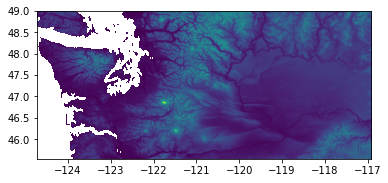

In [14]:
with rio.open(out_fn) as src:
    rio.plot.show(src)

Nice!  WA state really does have interesting topography.  
* Cascade mountains, Olympic Mountains, Active stratovolcanoes, Puget Sound, Columbia River
* Channeled Scablands: https://en.wikipedia.org/wiki/Channeled_Scablands

Much more interesting than Kansas:
* https://www.usu.edu/geo/geomorph/kansas.html

## Compare SRTM And Copernicus DEM

### Read the data and plot with matplotlib
* Read the data to a NumPy array
    * Note that the tiles on disk are not actually loaded until you `read` the dataset
    * Make sure you deal with nodata, either with a NumPy masked array, or setting nodata to np.nan (remember np.nan is a float, your input data type is int16)
* View with matplotlib imshow - verify you have a DEM of washington state

In [15]:
srtm_fn = 'WA_SRTMGL3.tif'
cop_fn = 'WA_COP90.tif'

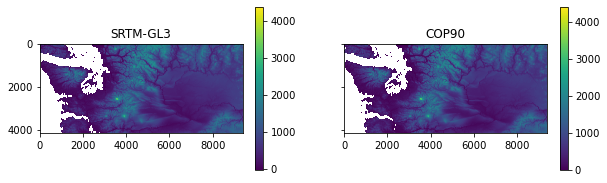

In [16]:
f, axa = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,3))
#One call to open, read and plot with imshow. Stores output from imshow (mappapble object) to create colorbar
m = axa[0].imshow(rio.open(srtm_fn).read(1, masked=True))
axa[0].set_title('SRTM-GL3')
f.colorbar(m, ax=axa[0])
m = axa[1].imshow(rio.open(cop_fn).read(1, masked=True))
axa[1].set_title('COP90')
f.colorbar(m, ax=axa[1]);

### Set nodata value for Copernicus DEM to 0
* Note: The Copernicus DEM creators filled water with values of 0.0 above the EGM2008 geoid (approximates mean sea level)
* We can set these to nodata to conly consider land. This is a bit of a hack, and it is possible that there are real elevations at 0 m that will be masked here.  

In [17]:
#Open file in read/write mode
#https://rasterio.readthedocs.io/en/latest/api/rasterio.html?highlight=open#rasterio.open
with rio.open(cop_fn, 'r+') as src:
    src.nodata = 0.0

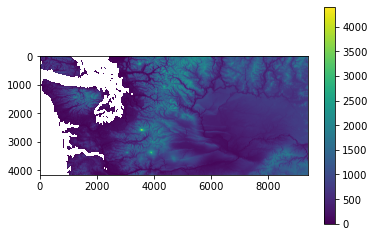

In [18]:
with rio.open(out_fn, 'r+') as src:
    f, ax = plt.subplots()
    src.nodata = 0.0
    dem = src.read(1, masked=True)
    m = ax.imshow(dem)
    plt.colorbar(m)

## Raster reprojection using GDAL and rasterio

#### Reproject the SRTM DEM to UTM 10N
* The SRTM grids are distributed with crs of EPSG:4326
* Let's reproject to a more appropriate coordinate system for WA state
    * Use EPSG:32610

In [19]:
dst_crs = 'EPSG:32610'

In [20]:
#Sadly, there is no `to_crs` method as in GeoPandas
#src.to_crs(dst_crs)

### First, reproject using `gdalwarp` command-line utility
* A very simple, efficient way to accomplish this - let GDAL worry about all of the underlying math
* Review the documentation and options here: https://gdal.org/programs/gdalwarp.html
    * Resampling options: https://gdal.org/programs/gdalwarp.html#cmdoption-gdalwarp-r 
* Save the projected file as a GeoTiff on disk
    * Use `cubic` resampling algorithm
* Note the filesize using `ls -lh`

In [21]:
proj_fn = os.path.splitext(out_fn)[0]+'_utm_gdalwarp.tif'

In [22]:
%%time
if not os.path.exists(proj_fn):
    !gdalwarp -overwrite -r cubic -t_srs $dst_crs $out_fn $proj_fn

CPU times: user 40 µs, sys: 0 ns, total: 40 µs
Wall time: 44.1 µs


In [23]:
ls -lh $proj_fn

-rw-r--r-- 1 jovyan users 199M Feb 18 18:58 WA_COP90_utm_gdalwarp.tif


In [24]:
!gdalinfo $proj_fn

Driver: GTiff/GeoTIFF
Files: WA_COP90_utm_gdalwarp.tif
Size is 8877, 5851
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 10N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 10N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-123,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],


### A note about "creation options" when writing a new file to disk
* Review this great reference on GeoTiff file format: https://www.gdal.org/frmt_gtiff.html
    * See Creation Options section toward bottom of page: https://gdal.org/drivers/raster/gtiff.html#creation-options
* I almost always use `-co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER`
    * Uses lossless LZW compression (we explored in LS8 example comparing filesize on disk to your calculated array filesize)
    * Writes the tif image in "tiles" of 256x256 px instead of one large block - makes it much more efficient to read and extract a subwindow from the tif
    * If necessary, use the BIGTIFF format for files that are >4 GB

### Write out the same file, but this time use tiling and LZW compression
* Compare the new filesize on disk

In [25]:
proj_fn_lzw = os.path.splitext(out_fn)[0]+'_utm_gdalwarp_lzw.tif'

In [26]:
%%time
#if not os.path.exists(proj_fn_lzw):
!gdalwarp -r cubic -t_srs $dst_crs -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER $out_fn $proj_fn_lzw

Warning 1: WA_COP90.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes
ERROR 1: Output dataset WA_COP90_utm_gdalwarp_lzw.tif exists,
but some command line options were provided indicating a new dataset
should be created.  Please delete existing dataset and run again.

CPU times: user 6.21 ms, sys: 11.4 ms, total: 17.6 ms
Wall time: 832 ms


In [27]:
ls -lh $proj_fn_lzw

-rw-r--r-- 1 jovyan users 176M Feb 18 18:59 WA_COP90_utm_gdalwarp_lzw.tif


In [28]:
#Let's use the compressed file from here on out
#Should compare runtimes when using compressed vs. uncompressed
proj_fn = proj_fn_lzw

In [29]:
!gdalinfo $proj_fn

Driver: GTiff/GeoTIFF
Files: WA_COP90_utm_gdalwarp_lzw.tif
Size is 8877, 5851
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 10N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 10N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-123,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806

### Load your reprojected dataset and plot

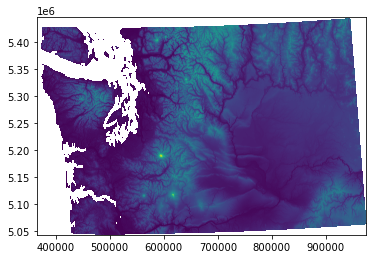

In [30]:
with rio.open(proj_fn) as src_proj:
    rio.plot.show(src_proj)

## Reprojection using rasterio API
* This is still surprisingly complicated compared to the GeoPandas `to_crs` method
    * But if you look at what's actually happening, it's not too bad
* See example here: https://rasterio.readthedocs.io/en/stable/topics/reproject.html#reprojecting-a-geotiff-dataset
* Define your coordinate system as `dst_crs` variable (needed later)
* Save the projected file as a GeoTiff on disk
    * print the metadata of your input and output datasets
    * If you are copying the metadata from your input dataset (as in the rasterio doc example), you will need to update the 'driver' to 'GTiff' before open the file for writing
    * Use cubic resampling algorithm
* You can specify these configuration options in the `rasterio.open()` kwargs:
    * https://github.com/mapbox/rasterio/blob/master/docs/topics/image_options.rst
    * https://rasterio.readthedocs.io/en/stable/topics/profiles.html
    * https://rasterio.readthedocs.io/en/stable/topics/configuration.html
* Note that it is also possible to reproject and store the resulting dataset in memory, rather than writing to disk
    * This is desirable if you need to temporarily reproject a raster dataset, read the array, do some analysis

In [31]:
def rio_reproj_write(src, proj_fn, dst_crs, driver='GTiff'):
    #Check to see if output filename already exists
    if os.path.exists(proj_fn):
        print("File exists: ", proj_fn)
    else:
        #Get the required transformation and output width and height
        transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
        #Create a copy of input metadata, then update with output values
        kwargs = src.meta.copy()
        print("Source metadata:\n", kwargs)
        kwargs.update({'crs':dst_crs,'transform':transform,'width':width,'height':height})
        kwargs['driver'] = driver
        #Set output creation options
        kwargs['compress'] = 'LZW'
        kwargs['tiled'] = True
        kwargs['BIGTIFF'] = 'IF_SAFER'
        print("Destination metadata:\n", kwargs)

        #Open the destination dataset in write mode
        with rio.open(proj_fn, 'w', **kwargs) as dst:
            print("Writing: ", proj_fn)
            #Loop through each input band
            for i in range(1, src.count + 1):
                #Reproject!
                reproject(source=rio.band(src, i), destination=rio.band(dst, i), src_transform=src.transform,\
                          src_crs=src.crs, dst_transform=transform, dst_crs=dst_crs, resampling=Resampling.cubic)
            print("Complete")

In [32]:
proj_fn = os.path.splitext(out_fn)[0]+'_utm_riowarp.tif'

with rio.open(out_fn) as src:
    rio_reproj_write(src, proj_fn, dst_crs)

File exists:  WA_COP90_utm_riowarp.tif


In [33]:
src_proj = rio.open(proj_fn)

In [34]:
src_proj.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 8877, 'height': 5851, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(68.74847128155481, 0.0, 364685.4908997369,
       0.0, -68.74847128155481, 5445638.415841511), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [35]:
src_proj.res

(68.74847128155481, 68.74847128155481)

In [36]:
#Load as a masked array
dem_proj = src_proj.read(1, masked=True)

In [37]:
dem_proj.shape

(5851, 8877)

## Discussion Questions
* What is the projected x and y cell size (output resolution)?
* Is this consistent with your expectation for the 90-m Copernicus DEM or 3-arcsec SRTM data?
    * Hint: Think about the dimensions of a pixel in meters near the top and bottom of the unprojected DEM grid. Then think back to Lab04 when we calculated length of a degree of longitude and a degree of latitude at different locations on the planet.
    * Info on an arcsecond: https://www.esri.com/news/arcuser/0400/wdside.html
* Note that if the output resolution is unspecified, GDAL and rasterio will estimate for you.  But you can also specify this output resolution (`-tr` argument in `gdalwarp`), if, for example, you wanted to resample your output to 180 m resolution.

In [38]:
src_proj.transform

Affine(68.74847128155481, 0.0, 364685.4908997369,
       0.0, -68.74847128155481, 5445638.415841511)

## Part 2: Create a shaded relief map (hillshade) from your projected DEM
* See background info on hillshades (and other DEM derivative products like slope and aspect) here: http://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/how-hillshade-works.htm
* Can do this easily with `gdaldem` command line utility: https://www.gdal.org/gdaldem.html
    * Try this and output to a new file
    * Note that if you were to run on a DEM with different horizontal and vertical units, (like say, degrees and meters), you will have scaling issues. There are ways around this, but Always generate hillshade using a projected DEM.

In [39]:
hs_fn = os.path.splitext(proj_fn)[0]+'_hs.tif'

In [40]:
%%time
if not os.path.exists(hs_fn):
    !gdaldem hillshade $proj_fn $hs_fn

CPU times: user 32 µs, sys: 9 µs, total: 41 µs
Wall time: 47.9 µs


### Use rasterio to load your GDAL shaded relief map as a NumPy masked array 
* Note that the datatype is 8-bit (Byte), with values from 0-255 (it's a grayscale image, not elevation data)
* Make sure you mask nodata values

In [41]:
hs_src = rio.open(hs_fn)
hs = hs_src.read(1, masked=True)

### Get the extent of the hillshade dataset in the projected coordinate system
* See `rio.plot.plotting_extent`
* Pass this to imshow `extent` and verify that your coordinates look good

In [42]:
hs_extent = rio.plot.plotting_extent(hs_src)
hs_extent

(364685.4908997369, 974965.6704660989, 5043391.110373134, 5445638.415841511)

In [43]:
f, ax = plt.subplots()
ax.imshow(hs, cmap='gray', extent=hs_extent);

### Example of hillshade using GDAL API
* Can also use GDAL Python API directly, rather than command line interface
    * Documentation of this functionality is poor, but it's pretty simple (see my example below)
    * Some examples are here: https://github.com/OSGeo/gdal/blob/master/autotest/utilities/test_gdaldem_lib.py

In [44]:
def gdal_hs_ds(fn):
    from osgeo import gdal
    #Open the GDAL dataset
    dem_ds = gdal.Open(fn)
    #Specify the type of product we want (e.g., hillshade, slope, aspect) - see gdaldem doc for list of avaiable options
    producttype = 'hillshade'
    #Create a GDAL hillshade dataset in memory
    hs_ds = gdal.DEMProcessing('', dem_ds, 'hillshade', format='MEM')
    return hs_ds

def gdal_hs_ma(fn):
    #Get GDAL Dataset
    hs_ds = gdal_hs_ds(fn)
    #Read the dataset as a NumPy array
    hs = hs_ds.ReadAsArray()
    return hs

In [45]:
#Create hillshade from a filename
#hs_ma = gdal_hs_ma(fn)
#plt.imshow(hs_ma, cmap='gray')

### Work in progress: dynamically create shaded relief, slope and aspect using numpy

In [46]:
#Function to return hillshade (for visualization), slope magnitude (deg) and aspect on the fly
#This is a work in progress, aspect values are incorrect!
def hillshade(a, res=1.0, sun_az=315, sun_el=45):
    sun_az = 360.0 - sun_az
    dx, dy = np.gradient(a, res)
    slope = np.pi/2. - np.arctan(np.sqrt(dx*dx + dy*dy))
    aspect = np.arctan2(-dx, dy)
    shaded = np.sin(np.radians(sun_az)) * np.sin(slope) + \
    np.cos(np.radians(sun_el)) * np.cos(slope) * \
    np.cos((np.radians(sun_az) - np.pi/2.) - aspect)
    hs = 255 * (shaded + 1)/2
    return hs, np.degrees(np.pi/2. - slope), np.degrees(aspect)

## Part 3: Clipping Raster data

#### Load the states GeoDataFrame

In [47]:
#states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'
states_gdf = gpd.read_file(states_url)
states_gdf.head()

GEO_ID STATE           NAME LSAD  CENSUSAREA  \
0  0400000US23    23          Maine        30842.923   
1  0400000US25    25  Massachusetts         7800.058   
2  0400000US26    26       Michigan        56538.901   
3  0400000US30    30        Montana       145545.801   
4  0400000US32    32         Nevada       109781.180   

                                            geometry  
0  MULTIPOLYGON (((-67.61976 44.51975, -67.61541 ...  
1  MULTIPOLYGON (((-70.83204 41.60650, -70.82373 ...  
2  MULTIPOLYGON (((-88.68443 48.11579, -88.67563 ...  
3  POLYGON ((-104.05770 44.99743, -104.25015 44.9...  
4  POLYGON ((-114.05060 37.00040, -114.04999 36.9...

#### Reproject the GeoDataFrame to match your DEM

In [48]:
states_gdf_proj = states_gdf.to_crs(dst_crs)

#### Isolate the WA state geometry object
* We want the geometry, not a GeoDataFrame or GeoSeries

In [49]:
wa_state = states_gdf_proj.loc[states_gdf_proj['NAME'] == 'Washington']
wa_geom = wa_state.iloc[0].geometry

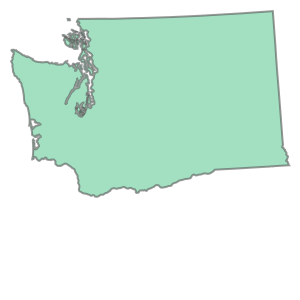

In [50]:
wa_geom

### Clip your projected DEM dataset (not the hillshade) to the WA state multipolygon
* This is a common GIS operation
* Some useful resources:
    * https://rasterio.readthedocs.io/en/stable/topics/masking-by-shapefile.html
    * https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html
    * https://www.earthdatascience.org/courses/earth-analytics-python/lidar-raster-data/crop-raster-data-with-shapefile-in-python/
* Note that input for rasterio `mask` is a rasterio dataset, not a numpy array
* Can experiment with different options (which are a bit different than other rasterio syntax):
    * These will return a masked array (and transform) ready for analysis: `filled=False, crop=True, indexes=1`
* Plot with `imshow` to verify - you should see a DEM clipped to WA state outline!
    * Use `rio.plot.plotting_extent` to get the projected coordinate extent, and pass this to the imshow `extent`
        * https://rasterio.readthedocs.io/en/latest/api/rasterio.plot.html#rasterio.plot.plotting_extent

In [51]:
#rio.mask.mask?

In [52]:
rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}

In [53]:
wa_ma, wa_ma_transform = rio.mask.mask(src_proj, wa_geom, **rio_mask_kwargs)

/srv/conda/envs/notebook/lib/python3.9/site-packages/rasterio/features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
/srv/conda/envs/notebook/lib/python3.9/site-packages/rasterio/features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):


In [54]:
wa_ma.shape

(5834, 8728)

In [55]:
wa_ma_transform

Affine(68.74847128155481, 0.0, 371079.0987289215,
       0.0, -68.74847128155481, 5444607.188772288)

In [56]:
#Get clipped extent in UTM coordaintes
wa_ma_extent = rio.plot.plotting_extent(wa_ma, wa_ma_transform)
wa_ma_extent

(371079.0987289215, 971115.7560743319, 5043528.607315698, 5444607.188772288)

In [57]:
#Original unclipped extent for comparison
src_proj.bounds

BoundingBox(left=364685.4908997369, bottom=5043391.110373134, right=974965.6704660989, top=5445638.415841511)

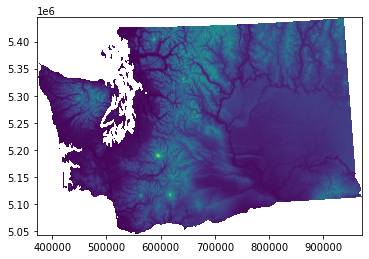

In [58]:
f, ax = plt.subplots()
ax.imshow(wa_ma, extent=wa_ma_extent);

## Part 4: Comparing and differencing rasters
* Often have two products with different resolution, extent, projection
* Want to combine, or use for some kind of raster math (e.g., subtract one from the other to compute difference)
* Relatively new package, `rioxarray` makes this very easy
    * https://corteva.github.io/rioxarray/stable/index.html
    * More on this in Week09 and Week10
    * Built for NetCDF model, but wraps rasterio for working with rasters
    * Lazy evaluation, doesn't read from disk util necessary
    * Built-in support for parallel operations using Dask

In [59]:
#Original SRTM DEM, still in EPSG:4326
srtm_fn

'WA_SRTMGL3.tif'

In [60]:
#Projected COP DEM, reprojected in EPSG:32610
proj_fn

'WA_COP90_utm_riowarp.tif'

### Open using rioxarray
* Open the two GeoTiff products as xarray DataSets (more on this in Week09)
    * https://corteva.github.io/rioxarray/html/rioxarray.html#rioxarray-open-rasterio
* Check out the spatial_ref attribute and access CRS
    * https://corteva.github.io/rioxarray/stable/getting_started/crs_management.html

In [61]:
#Note: since nodata is set, we can use masked=True to set those values to nan
#Using squeeze here to reduce the band=1 dimension
cop_xds = rioxarray.open_rasterio(proj_fn, masked=True).squeeze()
cop_xds

<xarray.DataArray (y: 5851, x: 8877)>
[51939327 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 3.647e+05 3.648e+05 ... 9.749e+05 9.749e+05
  * y            (y) float64 5.446e+06 5.446e+06 ... 5.043e+06 5.043e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [62]:
cop_xds.rio.crs

CRS.from_epsg(32610)

### Quick plotting using xarray
* https://xarray.pydata.org/en/stable/generated/xarray.plot.imshow.html

In [63]:
#Uses the contourf method - can fill memory!
#cop_xds.plot()

In [64]:
cop_xds.plot.imshow()

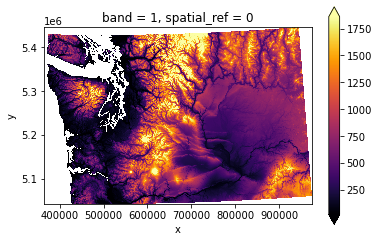

In [65]:
f, ax = plt.subplots()
cop_xds.plot.imshow(cmap='inferno', robust=True, ax=ax)
ax.set_aspect('equal')

### Open unprojected SRTM

In [66]:
srtm_xds = rioxarray.open_rasterio(srtm_fn, mask=True).squeeze()

In [67]:
srtm_xds

<xarray.DataArray (y: 4151, x: 9381)>
[38940531 values with dtype=int16]
Coordinates:
    band         int64 1
  * x            (x) float64 -124.7 -124.7 -124.7 ... -116.9 -116.9 -116.9
  * y            (y) float64 49.0 49.0 49.0 49.0 ... 45.55 45.55 45.55 45.54
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

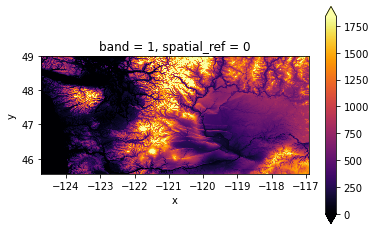

In [68]:
f, ax = plt.subplots()
srtm_xds.plot.imshow(cmap='inferno', robust=True, ax=ax)
ax.set_aspect('equal')

## Reproject and match
* Use the rioxarray `reproject_match` function
    * https://corteva.github.io/rioxarray/stable/examples/reproject_match.html
    * Resampling options: https://rasterio.readthedocs.io/en/stable/api/rasterio.enums.html#rasterio.enums.Resampling

In [69]:
srtm_xds_proj = srtm_xds.rio.reproject_match(cop_xds)

In [70]:
srtm_xds_proj

<xarray.DataArray (y: 5851, x: 8877)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)
Coordinates:
  * x            (x) float64 3.647e+05 3.648e+05 ... 9.749e+05 9.749e+05
  * y            (y) float64 5.446e+06 5.446e+06 ... 5.043e+06 5.043e+06
    band         int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    _FillValue:    0

In [71]:
srtm_xds_proj.rio.crs

CRS.from_epsg(32610)

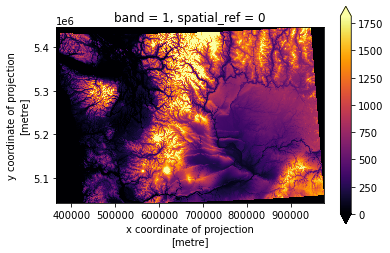

In [72]:
f, ax = plt.subplots()
srtm_xds_proj.plot.imshow(cmap='inferno', robust=True, ax=ax)
ax.set_aspect('equal')

In [73]:
diff = cop_xds - srtm_xds_proj

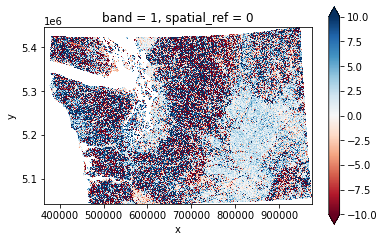

In [74]:
f, ax = plt.subplots()
diff.plot.imshow(cmap='RdBu', vmin=-10, vmax=10, ax=ax)
ax.set_aspect('equal')

### Using hvplot

In [75]:
import hvplot.xarray

In [76]:
#diff.hvplot(cmap='RdBu', clim=(-10,10), aspect='equal')

### Save difference map

In [77]:
diff_fn = 'WA_COP90_SRTMGL3_diff.tif'

In [78]:
diff.rio.to_raster(diff_fn)

In [79]:
!gdalinfo $diff_fn

Driver: GTiff/GeoTIFF
Files: WA_COP90_SRTMGL3_diff.tif
Size is 4759, 4546
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 10N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 10N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-123,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],


### Work in Progress: xarray-spatial
* New project implementing many raster/DEM analysis functions in Python with Dask/CUDA support
* Uses xarray data model (more complicated than rasterio dataset model)
* https://xarray-spatial.org/
* Surface functions: https://github.com/makepath/xarray-spatial#surface
    * Hillshade: https://xarray-spatial.org/reference/_autosummary/xrspatial.hillshade.hillshade.html#xrspatial.hillshade.hillshade

In [80]:
import xrspatial

In [81]:
#Run the hillshade operation
#hs = xrspatial.hillshade(cop_xds, azimuth=315, angle_altitude=45)
#Note: there are some coordinate scaling and nodata issues here
#hs.plot.imshow(cmap='gray');